 This notebook focuses on building a Support Vector Machine (SVM) classifier using the Breast Cancer Wisconsin dataset. The goal is to classify tumors as benign or malignant by applying a complete machine-learning workflow, including preprocessing, model training, hyperparameter tuning, and evaluation.

## 1.Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')


## 2.Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## 3.Dataset Structure and Missing Value Analysis
### 3.1 Check Basic Info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### 3.2 Check for null values

In [4]:

df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

### 3.3 Clean Dataset (drop empty column)

In [5]:
df = df.drop(columns=["Unnamed: 32"])

## 4. Prepare Features

In [6]:
df["diagnosis"] = df["diagnosis"].map({"M":1, "B":0})

X = df.drop(["diagnosis", "id"], axis=1)
y = df["diagnosis"]


## 5. Train/Val/Test Split

In [7]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, random_state=42, stratify=y_trainval)

X_train.shape, X_val.shape, X_test.shape


((397, 30), (86, 30), (86, 30))

## 6. Preprocessing Pipeline

In [8]:
numeric_cols = X.columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols)
    ]
)


## 7. Full Pipeline with SVM

In [9]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", SVC(probability=True))
])


## 8. Hyperparameter Tuning

In [10]:
param_grid = {
    "svm__kernel": ["linear", "rbf", "poly"],
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", "auto"],
    "svm__degree": [2,3]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring="accuracy",
    verbose=2
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END svm__C=0.1, svm__degree=2, svm__gamma=auto, svm__kernel=linear; total time=   0.0s
[CV] END svm__C=0.1, svm

## 9. Evaluate on Test Set

In [11]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.97      0.98        32

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



## 10.Evaluation Metrics

In [12]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

acc, prec, rec, f1, auc


(0.9883720930232558, 1.0, 0.96875, 0.9841269841269841, 1.0)

## 11. Confusion Matrix

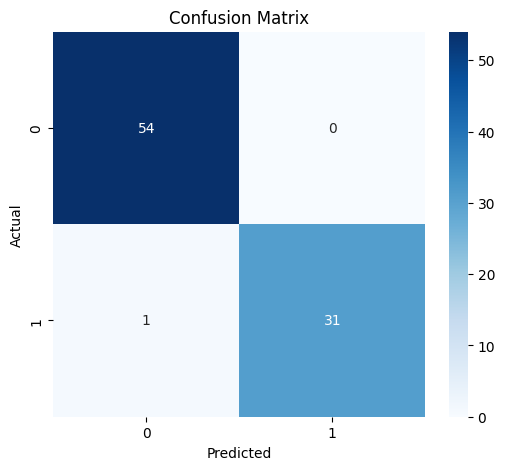

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 12. ROC Curve

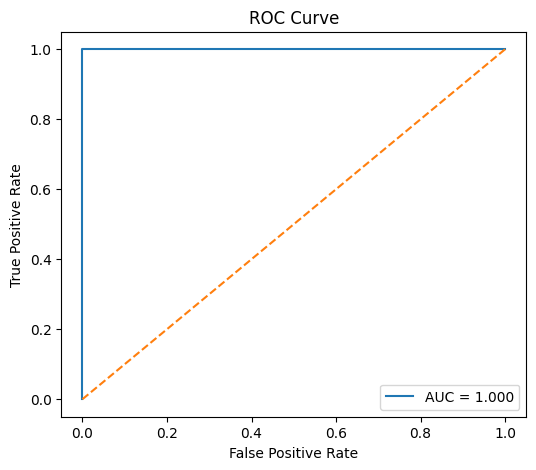

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## 13. Sample Predictions

In [15]:
sample = X_test.copy()
sample["Actual"] = y_test.values
sample["Predicted"] = y_pred
sample["Prob(Malignant)"] = y_prob
sample.head(10)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Actual,Predicted,Prob(Malignant)
420,11.570,19.04,74.20,409.7,0.08546,0.07722,0.05485,0.014280,0.2031,0.06267,...,520.5,0.1249,0.19370,0.25600,0.06664,0.3035,0.08284,0,0,0.014920
548,9.683,19.34,61.05,285.7,0.08491,0.05030,0.02337,0.009615,0.1580,0.06235,...,364.2,0.1199,0.09546,0.09350,0.03846,0.2552,0.07920,0,0,0.000767
371,15.190,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.026570,0.1721,0.05544,...,819.1,0.1126,0.17370,0.13620,0.08178,0.2487,0.06766,0,0,0.006862
503,23.090,19.83,152.10,1682.0,0.09342,0.12750,0.16760,0.100300,0.1505,0.05484,...,2782.0,0.1199,0.36250,0.37940,0.22640,0.2908,0.07277,1,1,1.000000
418,12.700,12.17,80.88,495.0,0.08785,0.05794,0.02360,0.024020,0.1583,0.06275,...,566.9,0.1314,0.16070,0.09385,0.08224,0.2775,0.09464,0,0,0.001869
534,10.960,17.62,70.79,365.6,0.09687,0.09752,0.05263,0.027880,0.1619,0.06408,...,407.5,0.1428,0.25100,0.21230,0.09861,0.2289,0.08278,0,0,0.002277
7,13.710,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.059850,0.2196,0.07451,...,897.0,0.1654,0.36820,0.26780,0.15560,0.3196,0.11510,1,1,0.934268
123,14.500,10.89,94.28,640.7,0.11010,0.10990,0.08842,0.057780,0.1856,0.06402,...,745.5,0.1313,0.17880,0.25600,0.12210,0.2889,0.08006,0,0,0.026227
325,12.670,17.30,81.25,489.9,0.10280,0.07664,0.03193,0.021070,0.1707,0.05984,...,574.4,0.1384,0.12120,0.10200,0.05602,0.2688,0.06888,0,0,0.005642
464,13.170,18.22,84.28,537.3,0.07466,0.05994,0.04859,0.028700,0.1454,0.05549,...,687.6,0.1282,0.19650,0.18760,0.10450,0.2235,0.06925,0,0,0.029545


## 14. 2D Classification Plot (PCA)

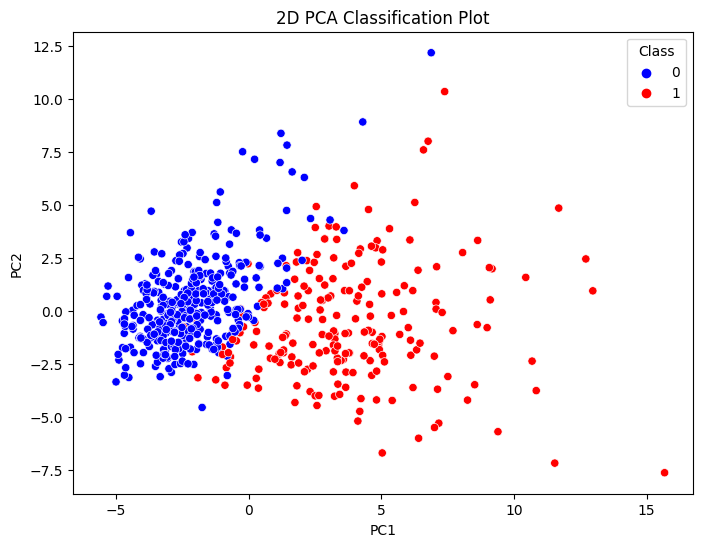

In [16]:
from sklearn.decomposition import PCA

X_processed = best_model.named_steps["preprocessor"].transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

df_pca = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "Class": y
})

plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="Class", data=df_pca, palette=["blue","red"])
plt.title("2D PCA Classification Plot")
plt.show()
